In [42]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from clean_data import clean_text
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import time
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Adjust the path to the project root (assuming the notebook is two levels deep in the folder structure)
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))

# Add the project root to the Python path
sys.path.append(project_root)


## Carregar e Pré-processar o Dataset

In [3]:
# Carregar o dataset
csv_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'datasets', 'trainEN.csv'))

df = pd.read_csv(csv_path)
# Combinar colunas de título e texto
df['combined_text'] = df['title'] + " " + df['text']
df['clean_text'] = df['combined_text'].apply(clean_text)
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                       combined_text  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2  Why the Truth Might Get You Fired Why the Trut...   
3  15 Civilians Killed In Single US Airstrike Hav...   
4  Iranian woman jailed for fictional unpublished...   

                                          clean_text  
0  house dem aide didnt even see comeys letter ja...  
1  flynn hillary clinton big woman campus breitba...  
2  truth might get fired truth might get fired oc...  
3  15 civilian killed single u airstrike identifi...  
4  iranian woman jailed fictional unpublished sto...

## Vetorização dos Textos

In [4]:
# Vetorizar o dataset
#vectorizer = TfidfVectorizer(max_features=5000, min_df=3, max_df=0.7, ngram_range=(1, 2))
X = df['clean_text']
y = df['label']

# Exibir a forma da matriz resultante
X.shape

(20166,)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [6]:
vectorizer = TfidfVectorizer(stop_words='english',max_features=5000, min_df=3, max_df=0.7, ngram_range=(1, 2))

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

X_Train_embedded = TSNE(n_components=2).fit_transform(X)
print(X_Train_embedded.shape)


In [88]:
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC

# Initialize the SVC model and the PCA transformer
clf = SVC(C=19.0011, gamma=1.50001, kernel='rbf')
pca = TruncatedSVD(n_components=85)

# Transform the training data
X_train2 = pca.fit_transform(X_train_vectorized)

# Transform the test data
X_test2 = pca.transform(X_test_vectorized)

# Fit the model on the transformed training data
clf.fit(X_train2, y_train)

# Score the model on the transformed test data
score = clf.score(X_test2, y_test)
print("Model accuracy:", score)

Model accuracy: 0.9540495867768595


(14116, 2)


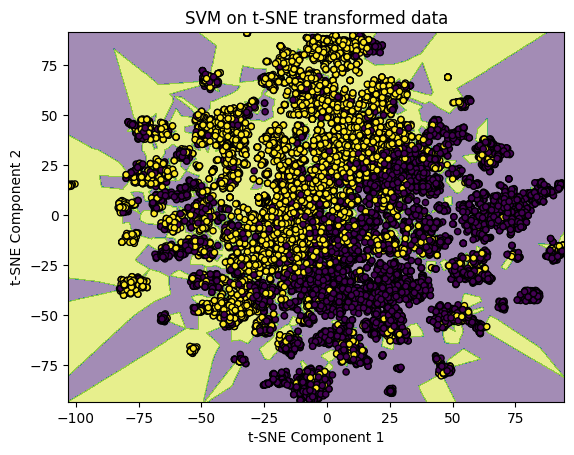

In [89]:
# Apply t-SNE for visualization
X_Train_embedded = TSNE(n_components=2).fit_transform(X_train2)
print(X_Train_embedded.shape)

# Predict using the trained model
y_predicted = clf.predict(X_train2)

# Plot decision regions using 1-NN on the t-SNE transformed data
h = .02  # mesh step
resolution = 1000 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:, 0]), np.max(X_Train_embedded[:, 0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:, 1]), np.max(X_Train_embedded[:, 1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# Approximate Voronoi tessellation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted)
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

# Plot
plt.contourf(xx, yy, voronoiBackground, alpha=0.5)
plt.scatter(X_Train_embedded[:, 0], X_Train_embedded[:, 1], c=y_train, edgecolor='k', s=20)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('SVM on t-SNE transformed data')
plt.show()

## Divisão dos Dados em Treino e Teste

## Definição e Treino da Pipeline

In [ ]:
from sklearn.decomposition import TruncatedSVD
# Definição da pipeline
# Definição da pipeline with RBF SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, min_df=3, max_df=0.7, ngram_range=(1, 2))),
    ('scaler', StandardScaler(with_mean=False)),
    ('svd', TruncatedSVD(n_components=2)),
    ('classifier', SVC(C=10000, gamma=6,kernel='rbf'))  # RBF kernel
])

# Treino do modelo
start_time = time.time()
pipeline.fit(df['clean_text'], df['label'])
print(f'Tempo total de execução: {time.time() - start_time:.2f} segundos')


Decision Regions Plot

In [ ]:
from mlxtend.plotting import plot_decision_regions
# Extract the TruncatedSVD and SVC from the pipeline
svd = pipeline.named_steps['svd']
svc = pipeline.named_steps['classifier']

# Transform the text data to 2D
X_transformed = svd.transform(pipeline.named_steps['tfidf'].transform(df['clean_text']))
y = df['label'].values

# Plot the decision boundaries
plt.figure(figsize=(10, 6))
plot_decision_regions(X_transformed, y, clf=svc, legend=2)
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('Decision Regions with SVD and SVM')
plt.show()

## Avaliação do Modelo

In [ ]:
# Previsão e avaliação
y_pred = pipeline.predict(df['clean_text'])
accuracy = accuracy_score(df['label'], y_pred)
print(f'Precisao do modelo: {accuracy:.2f}')

# Relatório de classificação
print(classification_report(df['label'], y_pred))

# Definição do k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Executar cross-validation
cross_val_scores = cross_val_score(pipeline, df['clean_text'], df['label'], cv=cv, scoring='accuracy')
print(f'Precisão média do cross-validation: {cross_val_scores.mean():.4f}')
print(f'Desvio padrão do cross-validation: {cross_val_scores.std():.4f}')


## Grid Search

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, min_df=3, max_df=0.7, ngram_range=(1, 2))),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', SVC())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'tfidf__max_features': [3000, 5000, 7000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'classifier__kernel': ['rbf'],
    'classifier__C': [0.1, 1, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(df['clean_text'], df['label'])

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.2f}")

# Predict using the best estimator
y_pred = grid_search.best_estimator_.predict(df['clean_text'])
accuracy = accuracy_score(df['label'], y_pred)
print(f"Accuracy on the full dataset: {accuracy:.2f}")

# Classification report
print(classification_report(df['label'], y_pred, digits=4))


In [ ]:
print(classification_report(df['label'], y_pred, digits=4))
#plot confusion matrix

In [ ]:
import joblib
#joblib.dump(grid_search.best_estimator_, 'clf.pkl') 
joblib.dump(grid_search, 'clf.pkl') 

In [ ]:
classifier = joblib.load('clf.pkl')



In [ ]:
#type(classifier)
classifier.predict(X_test)
